```python
#!/usr/bin/env python
# coding: utf-8 

#   This software component is licensed by ST under BSD 3-Clause license,
#   the "License"; You may not use this file except in compliance with the
#   License. You may obtain a copy of the License at:
#                        https://opensource.org/licenses/BSD-3-Clause
  

'''
Training script of human activity recognition system (HAR), based on two different Convolutional Neural Network (CNN) architectures 
'''
```

# Step by Step HAR Training STM32CubeAI
This notebook provides a step by step demonstration of a simple <u>H</u>uman <u>A</u>ctivity <u>R</u>ecognition system (HAR), based on a convolutional networks (CNN). This script provides a simple data preperation script through `DataHelper` class and let user to preprocess, split, and segment the dataset to bring it into the form which can be used for training and validation of the HAR CNN. It also has a `CNNHandler` class which builds, trains and validate a CNN for a given set of input and output tensors. The `CNNHandler` can create one of the two provided CNN architectures namely, **IGN** and **GMP**.

All the implementations are done in Python using [Keras](https:keras.io/) with [Tensorflow](https://www.tensorflow.org/) as backend.

For demonstration purposes this script uses two datasets created for HAR using accelerometer sensor. 

* WISDM, a public dataset provided by <u>WI</u>reless <u>S</u>ensing <u>D</u>ata <u>M</u>ining group. The details of the dataset are available [here](http://www.cis.fordham.edu/wisdm/dataset.php).

* AST our own propritery dataset.

**Note**: We are not providing any dataset in the function pack. The user can download WISDM dataset from [here](http://www.cis.fordham.edu/wisdm/dataset.php), while AST is a private dataset and is not provided.

Following figure shows the detailed workflow of HAR.


<p align="center">
<img width="760" height="400" src="workflow.png">
</p>

Let us start the implementation now.

## Step1 : Import necessary dependencies
Following section imports all the required dependencies. This also sets seeds for random number generators in Numpy and Tensorflow environments to make the results reproducibile.

In [1]:
import numpy as np
np.random.seed(611)

import argparse, os, logging, warnings
from os.path import isfile, join
from datetime import datetime

# private libraries
from PrepareDataset import DataHelper
from HARNN import ANNModelHandler

# for using callbacks to save the model during training and comparing the results at every epoch
from keras.callbacks import ModelCheckpoint

# disabling annoying warnings originating from Tensorflow
logging.getLogger('tensorflow').disabled = True

import tensorflow as tf
tf.compat.v1.set_random_seed(611)

# disabling annoying warnings originating from python
warnings.simplefilter("ignore")

## Step2: Set environment variables
Following section sets some user variables which will later be used for:

* preparing the dataset.
* preparing the neural networks.
* training the neural networks.
* validating the neural network.

In [2]:
# data variables
dataset = 'WISDM'
merge = True
segmentLength = 120
stepSize = 120
dataDir = 'datasets/ai_logged_data'
preprocessing = True

# neural network variables
modelName = 'IGN'

# training variables
trainTestSplit = 0.7
trainValidationSplit = 0.6
nEpochs = 250
learningRate = 0.0001
decay = 7e-6
batchSize = 64
verbosity = 1
nrSamplesPostValid = 2

## Step3: Result directory
Each run can have different variables and to compare the results of different choices, such as different segment size for the window for data, different overlap settings etc, we need to save the results. Following section creates a result directory to save results for the current run. The name of the directory has following format. `Mmm_dd_yyyy_hh_mm_ss_dataset_model_seqLen_stepSize_epochs_results`, and example name for directory can be `Oct_24_2019_14_31_20_WISDM_IGN_24_16_20_results`, which shows the process was started at October 24, 2019, at 14:31:20, the dataset used was WISDM, with segment size = 24, segment step = 16, and Nr of epochs = 20.

In [3]:
# if not already exist create a parent directory for results.
if not os.path.exists( './results/'):
    os.mkdir( './results/' )
resultDirName = 'results/{}/'.format(datetime.now().strftime( "%Y_%b_%d_%H_%M_%S" ) )
os.mkdir( resultDirName )
infoString = 'runTime : {}\nDatabase : {}\nNetwork : {}\nSeqLength : {}\nStepSize : {}\nEpochs : {}\n'.format( datetime.now().strftime("%Y-%b-%d at %H:%M:%S"), dataset, modelName, segmentLength, stepSize, nEpochs )
with open( resultDirName + 'info.txt', 'w' ) as text_file:
    text_file.write( infoString )

## Step4: Create a `DataHelper` object
The script in the following section creates a `DataHelper` object to preprocess, segment and split the dataset as well as to create one-hot-code labeling for the outputs to make the data training and testing ready using the choices set by the user in **Step2**.

In [4]:
myDataHelper = DataHelper( dataset = dataset, loggedDataDir = dataDir, merge = merge,
                            modelName = modelName, seqLength = segmentLength, seqStep = stepSize,
                            preprocessing = preprocessing, trainTestSplit = trainTestSplit,
                            trainValidSplit = trainValidationSplit, resultDir = resultDirName )

## Step5: Prepare the dataset
Following section prepares the dataset and create six tensors namely `TrainX`, `TrainY`, `ValidationX`, `ValidationY`, `TestX`, `TestY`. Each of the variables with trailing `X` are the inputs with shape `[_, segmentLength, 3, 1 ]`and each of the variables with trailing `Y` are corresponding outputs with shape `[ _, NrClasses ]`. `NrClasses` for `WISDM` can be `4` or `6` and for `AST` is `5`.

In [5]:
#TrainX, TrainY, ValidationX, ValidationY, TestX, TestY = myDataHelper.prepare_data()
TrainX, TrainY, ValidationX, ValidationY, TestX, TestY = myDataHelper.prepare_self_logged_data()

preparing data file from all the files in directory  datasets/ai_logged_data
parsing data from  IoT01-MemsAnn_25_Dec_20_16h_18m_38s.csv
parsing data from  IoT01-MemsAnn_25_Dec_20_17h_17m_53s.csv
parsing data from  IoT01-MemsAnn_25_Dec_20_17h_19m_36s.csv
parsing data from  IoT01-MemsAnn_26_Dec_20_12h_43m_31s.csv
parsing data from  IoT01-MemsAnn_26_Dec_20_12h_45m_12s.csv
parsing data from  IoT01-MemsAnn_25_Dec_20_16h_19m_38s.csv
parsing data from  IoT01-MemsAnn_25_Dec_20_16h_19m_50s.csv
parsing data from  IoT01-MemsAnn_26_Dec_20_12h_40m_35s.csv
parsing data from  IoT01-MemsAnn_25_Dec_20_17h_18m_22s.csv
parsing data from  IoT01-MemsAnn_25_Dec_20_17h_18m_42s.csv
parsing data from  IoT01-MemsAnn_25_Dec_20_16h_19m_05s.csv
parsing data from  IoT01-MemsAnn_26_Dec_20_12h_42m_58s.csv
parsing data from  IoT01-MemsAnn_25_Dec_20_16h_19m_18s.csv
parsing data from  IoT01-MemsAnn_26_Dec_20_12h_44m_27s.csv
parsing data from  IoT01-MemsAnn_25_Dec_20_17h_17m_20s.csv
parsing data from  IoT01-MemsAnn_25_De


Segmenting the AI logged Test data



Segmentation finished!


## Step6: Create a `ANNModelHandler` object
The script in the following section creates a `ANNModelHandler` object to create, train and validate the <u>A</u>rtificial <u>N</u>eural <u>N</u>etwork (ANN) using the variables created in **Step2**.

In [6]:
myHarHandler = ANNModelHandler( modelName = modelName, classes = myDataHelper.classes, resultDir = resultDirName,
                              inputShape = TrainX.shape, outputShape = TrainY.shape, learningRate = learningRate,
                              decayRate = decay, nEpochs = nEpochs, batchSize = batchSize,
                              modelFileName = 'har_' + modelName, verbosity = verbosity )

## Step6: Create a ANN model
Following script creates the ANN and prints its summary to show the architecture and nr of parameters for ANN.

In [7]:
harModel = myHarHandler.build_model()
harModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 105, 3, 24)        408       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 3, 24)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2520)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                30252     
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 26        
Total params: 30,686
Trainable params: 30,686
Non-trainable params: 0
____________________________________________________

## Step7: Create a Checkpoint for ANN training
The following script creates a check point for the training process of ANN to save the neural network as `h5` file. The settings are used in a way that the validation accuracy `val_acc` is maximized.

In [8]:
harModelCheckPoint = ModelCheckpoint( filepath = join(resultDirName, 'har_' + modelName + '.h5'),
                                     monitor = 'val_acc', verbose = 0, save_best_only = True, mode = 'max' )

## Step7 : Train the created neural network
The following script trains the created neural network with the provided checkpoint and created datasets.

Epoch 1/250
3/3 [==============================] - 1s 205ms/step - loss: 3.2311 - acc: 0.4524 - val_loss: 4.3025 - val_acc: 0.5500
Epoch 2/250
3/3 [==============================] - 0s 33ms/step - loss: 5.7862 - acc: 0.5482 - val_loss: 4.5726 - val_acc: 0.6000
Epoch 3/250
3/3 [==============================] - 0s 33ms/step - loss: 4.2081 - acc: 0.6650 - val_loss: 4.6829 - val_acc: 0.6600
Epoch 4/250
3/3 [==============================] - 0s 31ms/step - loss: 9.3205 - acc: 0.6647 - val_loss: 4.1981 - val_acc: 0.6300
Epoch 5/250
3/3 [==============================] - 0s 33ms/step - loss: 1.9229 - acc: 0.6933 - val_loss: 4.1376 - val_acc: 0.6000
Epoch 6/250
3/3 [==============================] - 0s 33ms/step - loss: 3.8074 - acc: 0.6141 - val_loss: 4.1060 - val_acc: 0.6300
Epoch 7/250
3/3 [==============================] - 0s 33ms/step - loss: 3.0726 - acc: 0.6575 - val_loss: 4.1034 - val_acc: 0.6200
Epoch 8/250
3/3 [==============================] - 0s 30ms/step - loss: 3.0417 - acc: 0.6

3/3 [==============================] - 0s 32ms/step - loss: 0.9827 - acc: 0.8587 - val_loss: 4.4849 - val_acc: 0.8400
Epoch 64/250
3/3 [==============================] - 0s 34ms/step - loss: 0.7225 - acc: 0.8896 - val_loss: 4.3570 - val_acc: 0.8400
Epoch 65/250
3/3 [==============================] - 0s 29ms/step - loss: 0.8427 - acc: 0.9107 - val_loss: 4.2561 - val_acc: 0.8400
Epoch 66/250
3/3 [==============================] - 0s 29ms/step - loss: 1.3070 - acc: 0.8618 - val_loss: 4.2218 - val_acc: 0.8400
Epoch 67/250
3/3 [==============================] - 0s 30ms/step - loss: 0.8510 - acc: 0.8449 - val_loss: 4.2421 - val_acc: 0.8400
Epoch 68/250
3/3 [==============================] - 0s 29ms/step - loss: 0.9048 - acc: 0.8421 - val_loss: 4.3161 - val_acc: 0.8400
Epoch 69/250
3/3 [==============================] - 0s 29ms/step - loss: 0.7046 - acc: 0.8823 - val_loss: 4.4006 - val_acc: 0.8400
Epoch 70/250
3/3 [==============================] - 0s 29ms/step - loss: 1.3613 - acc: 0.8340 - 

3/3 [==============================] - 0s 28ms/step - loss: 0.4186 - acc: 0.9340 - val_loss: 6.3354 - val_acc: 0.9200
Epoch 126/250
3/3 [==============================] - 0s 31ms/step - loss: 0.5719 - acc: 0.9273 - val_loss: 6.3420 - val_acc: 0.9200
Epoch 127/250
3/3 [==============================] - 0s 31ms/step - loss: 0.4189 - acc: 0.9486 - val_loss: 6.2611 - val_acc: 0.9200
Epoch 128/250
3/3 [==============================] - 0s 30ms/step - loss: 0.4833 - acc: 0.9175 - val_loss: 6.1955 - val_acc: 0.9300
Epoch 129/250
3/3 [==============================] - 0s 30ms/step - loss: 0.3484 - acc: 0.9450 - val_loss: 6.1601 - val_acc: 0.9300
Epoch 130/250
3/3 [==============================] - 0s 32ms/step - loss: 0.5885 - acc: 0.9427 - val_loss: 6.1475 - val_acc: 0.9300
Epoch 131/250
3/3 [==============================] - 0s 33ms/step - loss: 0.3627 - acc: 0.9340 - val_loss: 6.1451 - val_acc: 0.9300
Epoch 132/250
3/3 [==============================] - 0s 30ms/step - loss: 0.4458 - acc: 0.

3/3 [==============================] - 0s 31ms/step - loss: 0.2506 - acc: 0.9803 - val_loss: 6.7021 - val_acc: 0.9500
Epoch 188/250
3/3 [==============================] - 0s 30ms/step - loss: 0.2829 - acc: 0.9662 - val_loss: 6.7312 - val_acc: 0.9500
Epoch 189/250
3/3 [==============================] - 0s 32ms/step - loss: 0.3463 - acc: 0.9497 - val_loss: 6.7621 - val_acc: 0.9400
Epoch 190/250
3/3 [==============================] - 0s 29ms/step - loss: 0.2809 - acc: 0.9756 - val_loss: 6.7385 - val_acc: 0.9500
Epoch 191/250
3/3 [==============================] - 0s 29ms/step - loss: 0.2719 - acc: 0.9478 - val_loss: 6.7155 - val_acc: 0.9500
Epoch 192/250
3/3 [==============================] - 0s 29ms/step - loss: 0.3634 - acc: 0.9506 - val_loss: 6.6993 - val_acc: 0.9500
Epoch 193/250
3/3 [==============================] - 0s 29ms/step - loss: 0.2688 - acc: 0.9753 - val_loss: 6.6937 - val_acc: 0.9500
Epoch 194/250
3/3 [==============================] - 0s 28ms/step - loss: 0.3312 - acc: 0.

3/3 [==============================] - 0s 30ms/step - loss: 0.2210 - acc: 0.9745 - val_loss: 7.3092 - val_acc: 0.9400
Epoch 250/250
3/3 [==============================] - 0s 28ms/step - loss: 0.1703 - acc: 0.9878 - val_loss: 7.3090 - val_acc: 0.9400


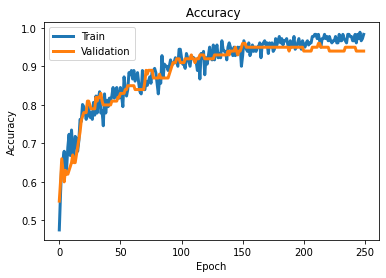

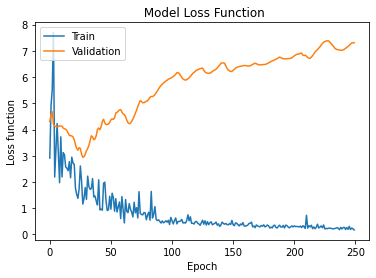

In [9]:
harModel = myHarHandler.train_model( harModel, TrainX, TrainY, ValidationX, ValidationY, harModelCheckPoint )

## Step8: Validating the trained neural network
The following section validates the created network and creates a confusion matrix for the test dataset to have a detailed picture of the errors.

3/3 [==============================] - 0s 3ms/step
Accuracy for each class is given below.
Gesture     : 100.0 %
Stationary  : 83.33 %


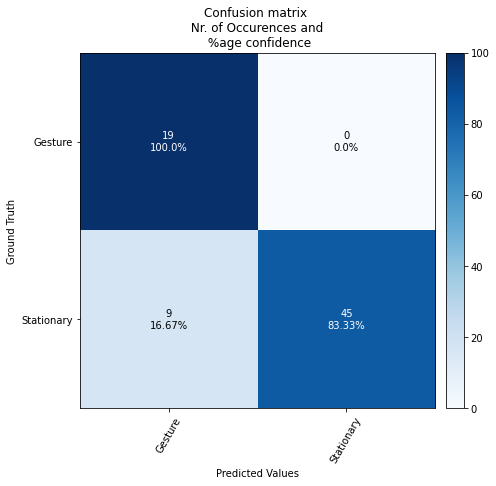

In [10]:
myHarHandler.make_confusion_matrix(  harModel, TestX, TestY )

## Step9: Create an npz file for validation after conversion from CubeAI.

In [11]:
myDataHelper.dump_data_for_post_validation( TestX, TestY, nrSamplesPostValid )